In [1]:
import sys
import os

# Add the parent folder to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import os
import sys
import numpy as np
import hydra

from VLA.dataset import RavensDataset
from VLA.utils import utils
from VLA import tasks
from VLA.environments.environment import Environment

import torch

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

pybullet build time: Sep  1 2024 19:11:17
/home/vishwak/Desktop/projects/Robotics/VLA/.env/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/vishwak/Desktop/projects/Robotics/VLA/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Generation

To generate data run
~~~
python3 demos.py n=10 mode=train task=align-rope data_dir=data
~~~

In [3]:
### task settings
mode = 'train'
augment = True

### Uncomment the task you want to generate ###
task = 'align-rope'
# task = 'assembling-kits-seq-seen-colors'
# task = 'assembling-kits-seq-unseen-colors'
# task = 'assembling-kits-seq-full'
# task = 'packing-shapes'
# task = 'place-red-in-green'
# task = 'packing-boxes-pairs-seen-colors'
# task = 'packing-boxes-pairs-unseen-colors'
# task = 'packing-boxes-pairs-full'
# task = 'packing-seen-google-objects-seq'
# task = 'packing-unseen-google-objects-seq'
# task = 'packing-seen-google-objects-group'
# task = 'packing-unseen-google-objects-group'
# task = 'put-block-in-bowl-seen-colors'
# task = 'put-block-in-bowl-unseen-colors'
# task = 'put-block-in-bowl-full'
# task = 'stack-block-pyramid-seq-seen-colors'
# task = 'stack-block-pyramid-seq-unseen-colors'
# task = 'stack-block-pyramid-seq-full'
# task = 'separating-piles-seen-colors'
# task = 'separating-piles-unseen-colors'
# task = 'separating-piles-full'
# task = 'towers-of-hanoi-seq-seen-colors'
# task = 'towers-of-hanoi-seq-unseen-colors'
# task = 'towers-of-hanoi-seq-full'

### visualization settings
max_episodes = 1
max_steps = 100

In [4]:
# Load configs
root_dir= '..'
config_file = 'train.yaml' 
cfg = utils.load_hydra_config(os.path.join('..', f'VLA/config/{config_file}'))

# Override defaults
cfg['task'] = task
cfg['mode'] = mode

data_dir = os.path.join(root_dir, 'data')

In [5]:
task = tasks.names[cfg['task']]()
task.mode = mode

ds = RavensDataset(os.path.join(data_dir, f'{cfg["task"]}-{cfg["mode"]}'), cfg, augment=augment)

In [6]:
ds.n_episodes

50

In [7]:
def visulaize():
    color_sums = []
    depth_sums = []
    
    total_images = 0
    
    for i in range(0, min(max_episodes, ds.n_episodes)):
        print(f'\n\nEpisode: {i + 1}/{ds.n_episodes}')
        episode, seed = ds.load(i)
        
        total_images += len(episode)-1
        
        total_reward = 0
        for step in range(min(max_steps, len(episode))):
            print(f"\nStep: {step+1}/{len(episode)}")
            obs, act, reward, info = episode[step]
            
            total_reward += reward
            batch = ds[i]
            
            num_images = len(obs['color'])
            fig, axs = plt.subplots(2, num_images+1, figsize=(15, 6))
            for n in range(num_images):
                axs[1, n].imshow(obs['color'][n])
                axs[1, n].set_title(f'Raw RGB {n+1}')
                
                axs[0, n].imshow(obs['depth'][n])
                axs[0, n].set_title(f'Raw Depth {n+1}')
                
            color_sums.append(np.mean(obs['color'][0], axis=(0,1)) / 255.0)
            depth_sums.append(np.mean(obs['depth'][0], axis=(0,1)))
            
            cam_config = None
            if b'camera_info' in info:
                cam_config = ds.get_cam_config(info[b'camera_info'])
            
            img_depth = ds.get_image(obs, cam_config=cam_config)
            img_tensor = torch.from_numpy(img_depth)
            img = np.uint8(img_tensor.detach().cpu().numpy())
            img = img.transpose(1,0,2)
            
            if step < len(episode)-1 and episode[step]:
                batch = ds.process_sample(episode[step], augment=augment)
            else:
                batch = ds.process_goal(episode[step], perturb_params=None)
            
            img_sample = batch['img']
            img_sample = torch.from_numpy(img_sample)
            color = np.uint8(img_sample.detach().cpu().numpy())[:,:,:3]
            color = color.transpose(1,0,2)
            depth = np.array(img_sample.detach().cpu().numpy())[:,:,3]
            depth = depth.transpose(1,0)
            
            axs[0, num_images].imshow(depth)
            axs[0, num_images].set_title('Depth')
            
            axs[1,num_images].imshow(color)
            axs[1,num_images].set_title('RGB + Oracle Pick & Place')
            
            if act and step < len(episode)-1:
                p0 = batch['p0']
                p1 = batch['p1']
                p0_theta = batch['p0_theta']
                p1_theta = batch['p1_theta'] + p0_theta
                
                pick = p0
                place = p1
                    
                line_len = 30
                pick0 = (pick[0] + line_len/2.0 * np.sin(p0_theta), pick[1] + line_len/2.0 * np.cos(p0_theta))
                pick1  = (pick[0] - line_len/2.0 * np.sin(p0_theta), pick[1] - line_len/2.0 * np.cos(p0_theta))
                axs[1,num_images].plot((pick1[0], pick0[0]), (pick1[1], pick0[1]), color='r', linewidth=2)
                
                place0 = (place[0] + line_len/2.0 * np.sin(p1_theta), place[1] + line_len/2.0 * np.cos(p1_theta))
                place1  = (place[0] - line_len/2.0 * np.sin(p1_theta), place[1] - line_len/2.0 * np.cos(p1_theta))
                axs[1,num_images].plot((place1[0], place0[0]), (place1[1], place0[1]), color='g', linewidth=2)
                
                c_pick = plt.Circle(pick, 3, color='r', fill=False)
                c_place = plt.Circle(place, 3, color='g', fill=False)
    
                axs[1,num_images].add_patch(c_pick)
                axs[1,num_images].add_patch(c_place)
                
            plt.show()
            
            print(f"Language Goal: {batch['lang_goal']}")
            print(f"Step Reward: {reward}")
            print(f"Total Reward: {total_reward}")
    
        print(f"Done, Total Reward: {total_reward}")



Episode: 1/50

Step: 1/7


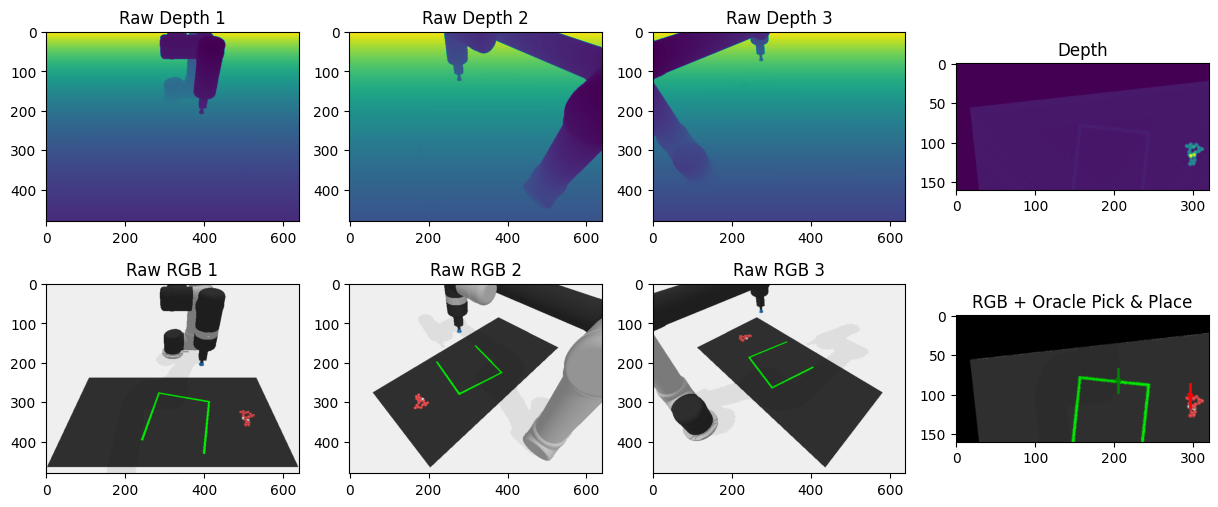

Language Goal: align the rope from back right corner to back left corner
Step Reward: 0
Total Reward: 0

Step: 2/7


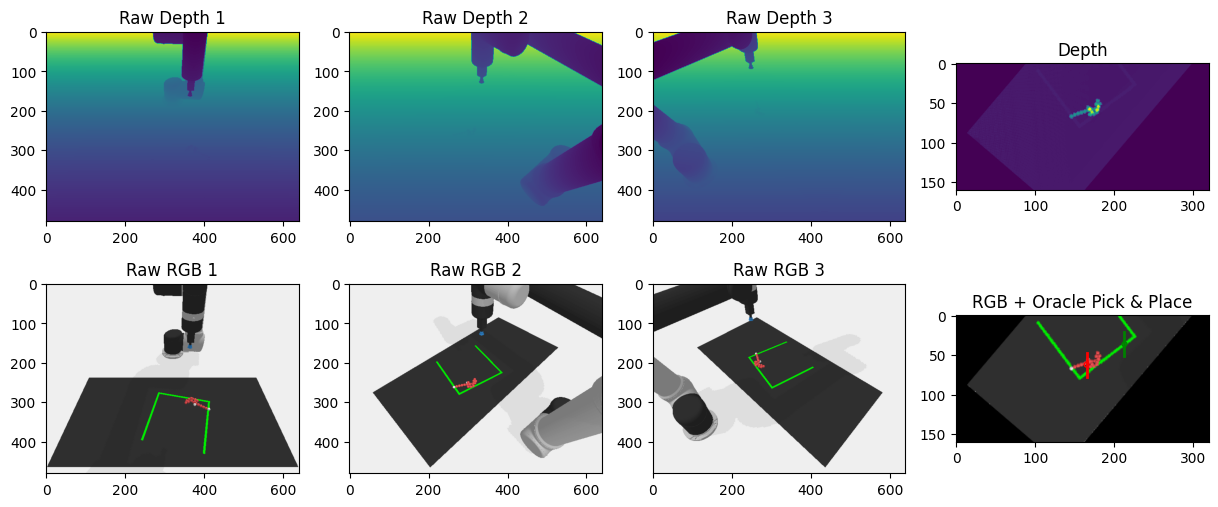

Language Goal: align the rope from back right corner to back left corner
Step Reward: 0.15000000000000002
Total Reward: 0.15000000000000002

Step: 3/7


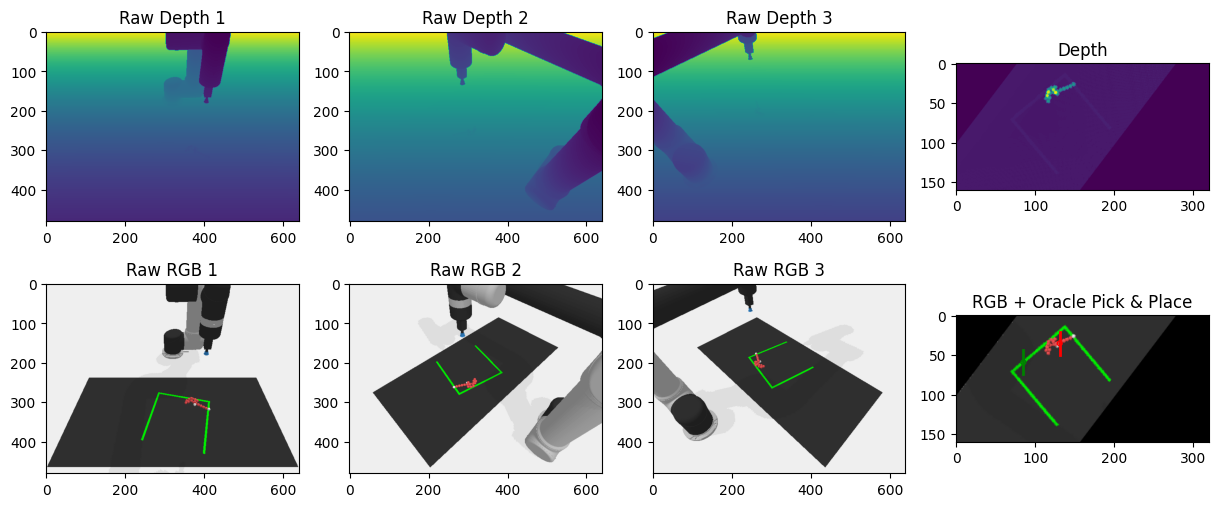

Language Goal: align the rope from back right corner to back left corner
Step Reward: 0.0
Total Reward: 0.15000000000000002

Step: 4/7


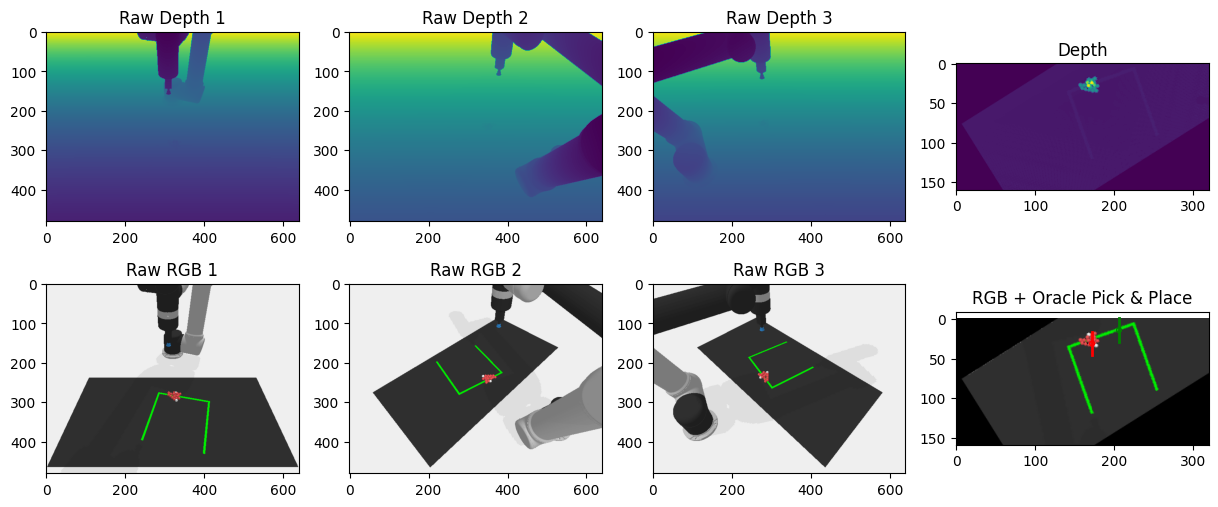

Language Goal: align the rope from back right corner to back left corner
Step Reward: 0.04999999999999999
Total Reward: 0.2

Step: 5/7


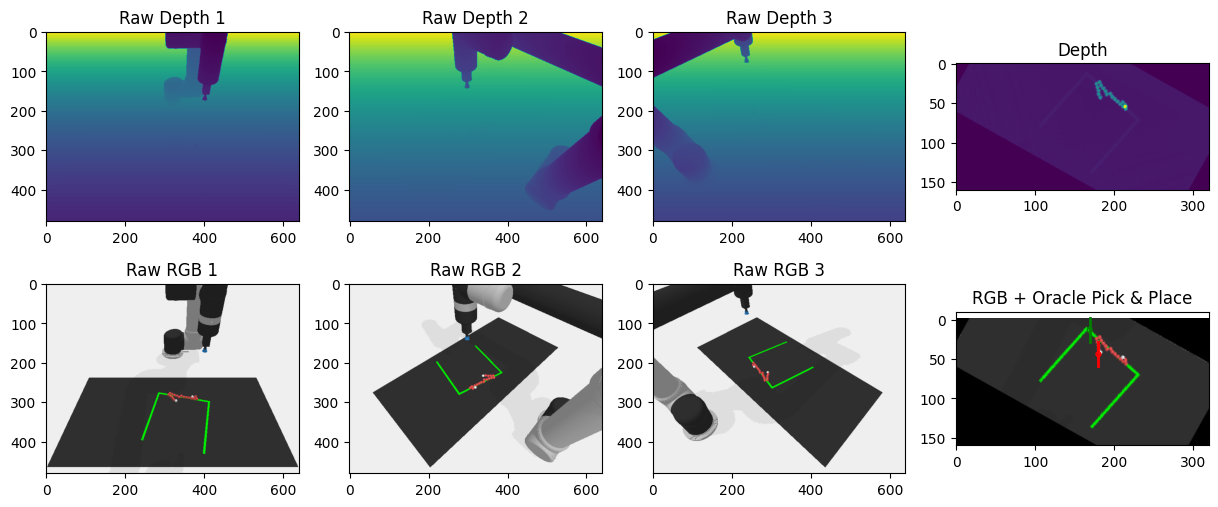

Language Goal: align the rope from back right corner to back left corner
Step Reward: 0.14999999999999997
Total Reward: 0.35

Step: 6/7


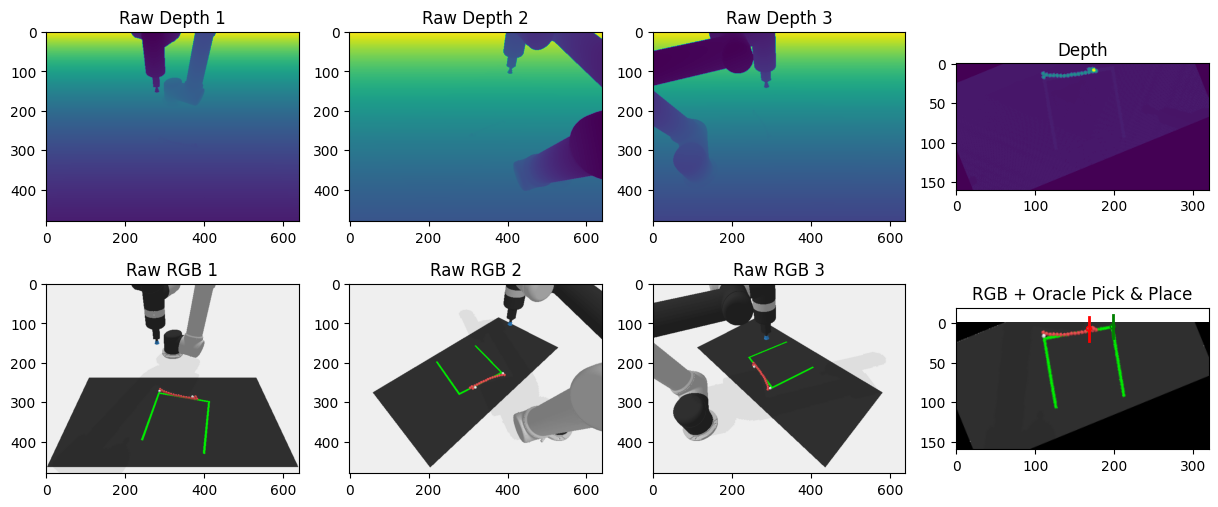

Language Goal: align the rope from back right corner to back left corner
Step Reward: -0.19999999999999996
Total Reward: 0.15000000000000002

Step: 7/7


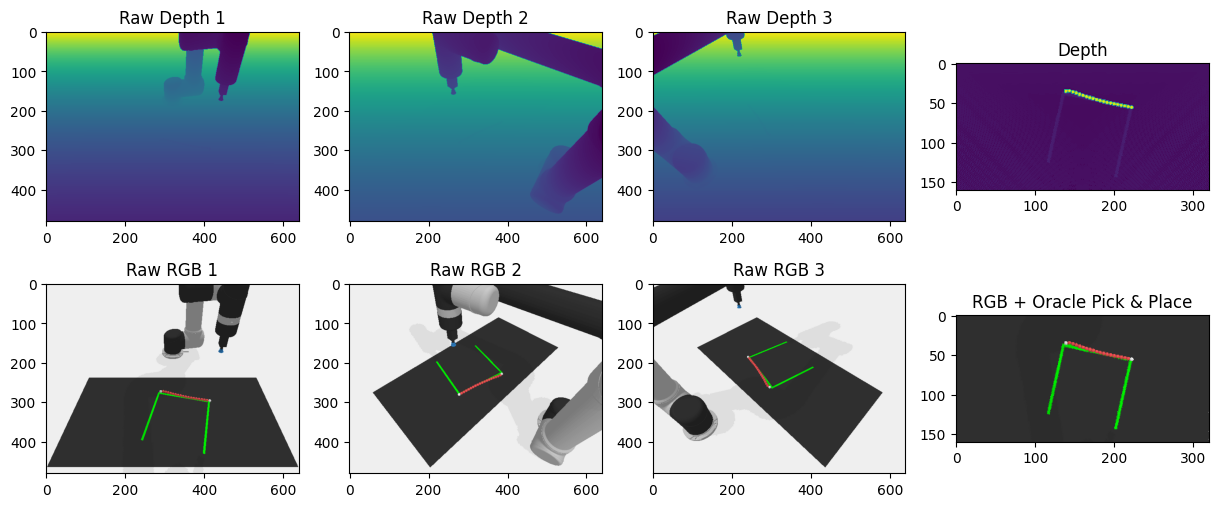

Language Goal: done aligning the rope.
Step Reward: 0.8500000000000002
Total Reward: 1.0000000000000002
Done, Total Reward: 1.0000000000000002


In [8]:
visulaize()

In [ ]:
print("\n\nDataset Statistics: ")
print(f"Color Mean: {np.mean(color_sums, axis=0)}, Std: {np.std(color_sums, axis=0)}")
print(f"Depth Mean: {np.mean(depth_sums, axis=0)}, Std: {np.std(depth_sums, axis=0)}")
print(f"Total Image-Action Pairs: {total_images}")